<a href="https://colab.research.google.com/github/ucaokylong/Some_small_projects/blob/main/Image_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
 # import libs
import os
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

from torchvision import datasets , models , transforms

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
 # download dataset
!gdown 11Buzytn4vIh4x_Oqz8MY29JMMdIqSzj-
!unzip ./flower_photos.zip

Downloading...
From (original): https://drive.google.com/uc?id=11Buzytn4vIh4x_Oqz8MY29JMMdIqSzj-
From (redirected): https://drive.google.com/uc?id=11Buzytn4vIh4x_Oqz8MY29JMMdIqSzj-&confirm=t&uuid=ecae4a07-2912-442f-93b5-3001210b6408
To: /content/flower_photos.zip
100% 230M/230M [00:02<00:00, 85.9MB/s]
Archive:  ./flower_photos.zip
   creating: flower_photos/
   creating: flower_photos/daisy/
  inflating: flower_photos/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flower_photos/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flower_photos/daisy/10172379554_b296050f82_n.jpg  
  inflating: flower_photos/daisy/10172567486_2748826a8b.jpg  
  inflating: flower_photos/daisy/10172636503_21bededa75_n.jpg  
  inflating: flower_photos/daisy/102841525_bd6628ae3c.jpg  
  inflating: flower_photos/daisy/1031799732_e7f4008c03.jpg  
  inflating: flower_photos/daisy/10391248763_1d16681106_n.jpg  
  inflating: flower_photos/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flower_photos/daisy/104377705

In [ ]:
 # load dataset from path
data_pth = "./flower_photos"
dataset = datasets . ImageFolder ( root = data_pth )


num_samples = len( dataset )
num_classes = len( dataset.classes )
num_samples , num_classes

(3670, 5)

In [ ]:
TRAIN_RATIO , VALID_RATIO = 0.8 , 0.1

n_train_examples = int( num_samples * TRAIN_RATIO )
n_valid_examples = int( num_samples * VALID_RATIO )
n_test_examples = num_samples - n_train_examples - n_valid_examples

train_dataset , valid_dataset , test_dataset = data.random_split(dataset ,
 [ n_train_examples , n_valid_examples , n_test_examples ])

In [ ]:
# resize + convert to tensor
IMG_SIZE = 224

train_transforms = transforms.Compose([
  transforms.Resize(( IMG_SIZE , IMG_SIZE ) ) ,
  transforms.RandomHorizontalFlip() ,
  transforms.RandomRotation(0.2) ,
  transforms.ToTensor() ,
  transforms.Normalize([0.5 , 0.5 , 0.5] , [0.5 , 0.5 , 0.5]) ])

test_transforms = transforms.Compose ([
  transforms.Resize(( IMG_SIZE , IMG_SIZE ) ) ,
  transforms.ToTensor() ,
  transforms.Normalize([0.5 , 0.5 , 0.5] , [0.5 , 0.5 , 0.5])])
train_dataset.dataset.transform = train_transforms
valid_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms


In [ ]:
# build dataloader
BATCH_SIZE = 128

train_dataloader = data.DataLoader(
  train_dataset ,
  shuffle = True ,
  batch_size = BATCH_SIZE
)

valid_dataloader = data.DataLoader(
  valid_dataset ,
  batch_size = BATCH_SIZE
)

test_dataloader = data.DataLoader(
  test_dataset ,
  batch_size = BATCH_SIZE
)

In [ ]:
def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch =0, log_interval =5):
  model.train()
  accs, losses = [], []
  start_time = time.time()

  for idx, (inputs, labels) in enumerate(train_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    predictions = model(inputs)

    #compute loss
    loss = criterion(predictions, labels)
    losses.append(loss.item())

    #backward
    loss.backward()
    optimizer.step()

    total_acc = ( predictions.argmax(1) == labels ).sum().item()
    acc = total_acc / labels.size(0)
    accs.append(acc)
    if idx % log_interval == 0 and idx > 0:
      elapsed = time.time() - start_time
      print (
            f"| epoch {epoch} | {idx}/{len( train_dataloader )} batches "
            f"| accuracy {sum( accs ) / len( accs )}"
      )
      start_time = time.time()

  epoch_acc = sum( accs ) / len( accs )
  epoch_loss = sum( losses ) / len( losses )
  return epoch_acc , epoch_loss

# evaluate
def evaluate_epoch( model , criterion , valid_dataloader ):
  model.eval()
  accs, losses = [] , []

  with torch.no_grad():
    for idx , ( inputs , labels ) in enumerate ( valid_dataloader ):
      inputs = inputs.to(device)
      labels = labels.to(device)
      predictions = model( inputs )

      loss = criterion(predictions , labels )
      losses.append(loss.item () )
      total_acc = ( predictions.argmax(1) == labels ).sum().item()
      acc = total_acc / labels.size(0)
      accs.append( acc )

  epoch_acc = sum( accs ) / len( accs )
  epoch_loss = sum( losses ) / len( losses )
  return epoch_acc , epoch_loss









In [ ]:
# train model
def train( model , model_name , save_model , optimizer , criterion , train_dataloader ,
           valid_dataloader , num_epochs , device ) :
  train_accs , train_losses = [] , []
  eval_accs , eval_losses = [] , []
  best_loss_eval = 100
  times = []
  for epoch in range(1 , num_epochs +1):
    epoch_start_time = time.time()

    # Training
    train_acc , train_loss = train_epoch( model , optimizer , criterion ,
                                          train_dataloader , device , epoch )
    train_accs.append( train_acc )
    train_losses.append( train_loss )

    # Evaluation
    eval_acc , eval_loss = evaluate_epoch( model , criterion , valid_dataloader )
    eval_accs.append( eval_acc )
    eval_losses.append( eval_loss )

    # Evaluation
    eval_acc , eval_loss = evaluate_epoch( model , criterion , valid_dataloader )
    eval_accs.append( eval_acc )
    eval_losses.append( eval_loss )

    # Save best model
    if eval_loss < best_loss_eval :
      torch.save( model.state_dict() , save_model + f'/{ model_name }.pt')

    times.append( time.time() - epoch_start_time )
    # Print loss , acc end epoch
    print ("-" * 59)
    print(
        "| End of epoch {:3d} | Time : {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(epoch , time.time() - epoch_start_time , train_acc , train_loss , eval_acc, eval_loss)
        )
    print ("-" * 59)


  # Load best model
  model.load_state_dict(torch.load( save_model + f'/{model_name}.pt'))
  model.eval()
  metrics = {"train_accuracy": train_accs,
             "train_loss": train_losses,
              "valid_accuracy": eval_accs,
              "valid_loss": eval_losses,
              "time": times}
  return model , metrics



In [ ]:
def plot_result( num_epochs , train_accs , eval_accs , train_losses , eval_losses ) :
  epochs = list(range( num_epochs) )
  fig , axs = plt.subplots( nrows = 1 , ncols =2 , figsize = (12 ,6) )
  axs[0].plot( epochs , train_accs , label = " Training ")
  axs[0].plot( epochs , eval_accs , label = " Evaluation ")
  axs[1].plot( epochs , train_losses , label = " Training ")
  axs[1].plot( epochs , eval_losses , label = " Evaluation ")
  axs[0].set_xlabel(" Epochs ")
  axs[1].set_xlabel(" Epochs ")
  axs[0].set_ylabel(" Accuracy ")
  axs[1].set_ylabel(" Loss ")
  plt.legend()

In [ ]:
# load model with weights = None
base_model = models.resnet18( weights = None )

# custom linear layer from 1000 classes ( ImageNet ) to 5 class ( Flower )
in_features = base_model.fc.in_features
base_model.fc = nn.Linear( in_features , num_classes )
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
base_model.to( device )
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam( base_model.parameters() , lr =0.0001)
num_epochs = 50
save_model = './ model'
os.makedirs( save_model , exist_ok = True )
model_name = 'base_model'

base_model , base_metrics = train(base_model , model_name , save_model , optimizer ,
                                  criterion , train_dataloader ,
                                  valid_dataloader , num_epochs , device)


| epoch 1 | 5/23 batches | accuracy 0.3893229166666667
| epoch 1 | 10/23 batches | accuracy 0.4680397727272727
| epoch 1 | 15/23 batches | accuracy 0.49951171875
| epoch 1 | 20/23 batches | accuracy 0.5208333333333334
-----------------------------------------------------------
| End of epoch   1 | Time : 23.85s | Train Accuracy    0.529 | Train Loss    1.163 | Valid Accuracy    0.264 | Valid Loss    1.946 
-----------------------------------------------------------
| epoch 2 | 5/23 batches | accuracy 0.66015625
| epoch 2 | 10/23 batches | accuracy 0.6598011363636364
| epoch 2 | 15/23 batches | accuracy 0.6640625
| epoch 2 | 20/23 batches | accuracy 0.6722470238095238
-----------------------------------------------------------
| End of epoch   2 | Time : 23.47s | Train Accuracy    0.673 | Train Loss    0.855 | Valid Accuracy    0.554 | Valid Loss    1.091 
-----------------------------------------------------------
| epoch 3 | 5/23 batches | accuracy 0.7513020833333334
| epoch 3 | 10/23

ValueError: x and y must have same first dimension, but have shapes (50,) and (100,)

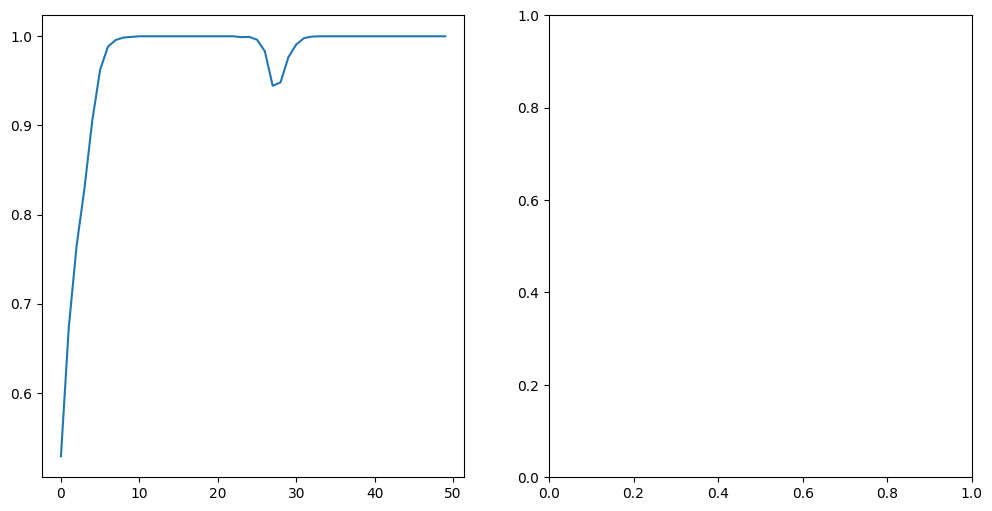

In [ ]:
plot_result( 50  , base_metrics['train_accuracy'] , base_metrics['valid_accuracy'] , base_metrics['train_loss'] ,base_metrics['valid_loss'] )

In [ ]:
# load model and its weight
fine_tuning_model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
# freeze the first 50 layers
num_layers = 50
for index , param in enumerate ( fine_tuning_model . parameters () ):
  if index < num_layers:
    param.requires_grad = False

# custom linear layer
in_features = fine_tuning_model.fc.in_features
fine_tuning_model.fc = nn.Linear( in_features , num_classes )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )
fine_tuning_model.to( device )

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam( fine_tuning_model.parameters() , lr =0.0001)


num_epochs = 50
save_model = './ model'
os.makedirs( save_model , exist_ok = True )
model_name = 'fine_tuning_model'

fine_tuning_model , fine_tuning_metrics = train(fine_tuning_model , model_name ,
                                                save_model , optimizer ,
                                                criterion , train_dataloader ,
                                                valid_dataloader , num_epochs , device)

| epoch 1 | 5/23 batches | accuracy 0.4505208333333333
| epoch 1 | 10/23 batches | accuracy 0.6001420454545454
| epoch 1 | 15/23 batches | accuracy 0.677734375
| epoch 1 | 20/23 batches | accuracy 0.7235863095238095
-----------------------------------------------------------
| End of epoch   1 | Time : 18.91s | Train Accuracy    0.741 | Train Loss    0.762 | Valid Accuracy    0.860 | Valid Loss    0.400 
-----------------------------------------------------------
| epoch 2 | 5/23 batches | accuracy 0.9075520833333334
| epoch 2 | 10/23 batches | accuracy 0.9169034090909091
| epoch 2 | 15/23 batches | accuracy 0.919921875
| epoch 2 | 20/23 batches | accuracy 0.9203869047619048
-----------------------------------------------------------
| End of epoch   2 | Time : 18.35s | Train Accuracy    0.922 | Train Loss    0.257 | Valid Accuracy    0.909 | Valid Loss    0.305 
-----------------------------------------------------------
| epoch 3 | 5/23 batches | accuracy 0.95703125
| epoch 3 | 10/23

In [1]:
#IMAGE RETRIEVAL
 # download unzip dataset
!gdown 1aZVKTLtWlrQOlLvepLasxy6qFuCl4SJm
!unzip /content/images_mr.zip #-d #/content/drive/MyDrive/img

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: images_mr/5415.jpg      
  inflating: images_mr/5416.jpg      
  inflating: images_mr/5417.jpg      
  inflating: images_mr/5418.jpg      
  inflating: images_mr/5419.jpg      
  inflating: images_mr/542.jpg       
  inflating: images_mr/5420.jpg      
  inflating: images_mr/5421.jpg      
  inflating: images_mr/5422.jpg      
  inflating: images_mr/5423.jpg      
  inflating: images_mr/5424.jpg      
  inflating: images_mr/5425.jpg      
  inflating: images_mr/5426.jpg      
  inflating: images_mr/5427.jpg      
  inflating: images_mr/5428.jpg      
  inflating: images_mr/5429.jpg      
  inflating: images_mr/543.jpg       
  inflating: images_mr/5430.jpg      
  inflating: images_mr/5431.jpg      
  inflating: images_mr/5432.jpg      
  inflating: images_mr/5433.jpg      
  inflating: images_mr/5434.jpg      
  inflating: images_mr/5435.jpg      
  inflating: images_mr/5436.jpg      
  inflating: images_mr/5437.jpg

In [4]:
 # load dataset
# Image transformation : resize and convert to tensor
transform = transforms.Compose([
transforms.Resize((86 , 128) ) ,
transforms.ToTensor() ,
])

# Function to load and preprocess the image
def load_image( path , transform ):
  img = Image.open( path ).convert('RGB')
  img_tensor = transform(img)
  return img_tensor

In [5]:
 # Img folder path and Save path ( Change if needed )
img_path = "/content/images_mr"
save_path = "/content/save_img_tensor.pt"

In [6]:
!pip install tqdm

In [7]:
from tqdm import tqdm
# Save images as tensor
lists = [i for i in range(9908)]
images = []

for index in tqdm(lists):
# Load image
  try:
    img_tensor = load_image( f'{img_path}/{index}.jpg', transform )
    images.append(img_tensor)
  except FileNotFoundError:
    print( f'Image file not found : {img_path}/{index}.jpg')

# Stack all image tensors into one big tensor
img_tensor = torch.stack(images)
print(img_tensor.shape)



100%|██████████| 9908/9908 [00:09<00:00, 1038.04it/s]


torch.Size([9908, 3, 86, 128])


In [8]:
# Install the required module
!pip install torchvision

import torch
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

img_tensors = img_tensor.type(torch.uint8)

 Saved tensor to /content/save_img_tensor.pt.


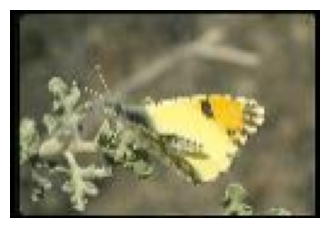

In [9]:
# Save the tensor
torch.save( img_tensor , save_path )
print( f" Saved tensor to {save_path}.")

# Load the img tensor file
img_tensors = torch.load( save_path )

# Convert the tensor to a PIL image
image_pil = ToPILImage()(img_tensors[0])


# Display the image using matplotlib
plt.figure(figsize =(4 , 4) )
plt.imshow(image_pil)
plt.axis('off') # Turn off axis numbers
plt.show()


Img tensor shape : torch.Size([3, 86, 128])


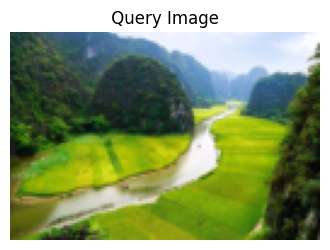

Img tensor shape : torch.Size([1, 33024])
Data tensors shape : torch.Size([9908, 3, 86, 128])
Data tensors shape : torch.Size([9908, 33024])


In [11]:
 # Load query image
query_img_path = '/content/NB.jpg' # Update with the correct path
query_tensor = load_image( query_img_path , transform )
print( f'Img tensor shape : { query_tensor.shape }')

# Display query image
plt.figure( figsize =(4 , 4) )
plt.imshow( transforms.ToPILImage()( query_tensor ) )
plt.title(" Query Image ")
plt.axis('off' )
plt.show()

# Flatten the query img
query_tensor_flat = query_tensor.view(1 , -1)
print( f'Img tensor shape : { query_tensor_flat.shape }')

# Load the saved tensor file containing all images
data_tensors = torch.load('/content/save_img_tensor.pt')
print(f'Data tensors shape : { data_tensors.shape }')
data_tensors_flat = data_tensors.view( data_tensors.size(0) , -1)
print(f'Data tensors shape : { data_tensors_flat.shape }')

Index : 5654 , Distance : 6344.1767578125
Index : 9794 , Distance : 6515.60400390625
Index : 4769 , Distance : 6609.9462890625
Index : 9531 , Distance : 6724.380859375
Index : 3562 , Distance : 6776.603515625
Index : 4799 , Distance : 6856.55322265625
Index : 4533 , Distance : 6912.54541015625
Index : 4744 , Distance : 6921.00830078125


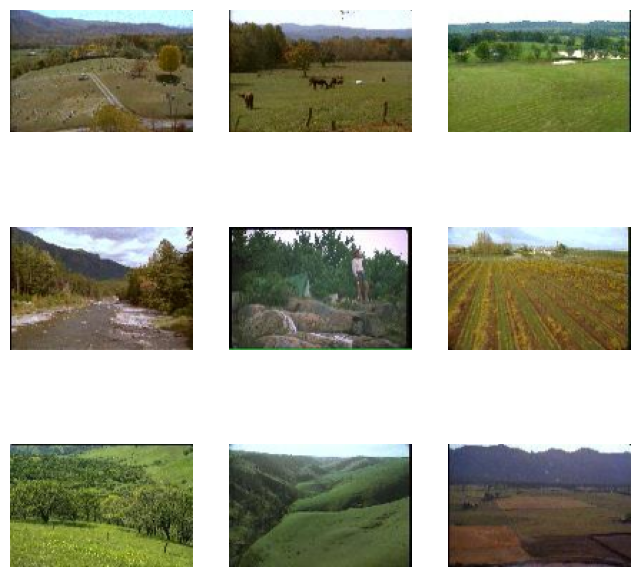

In [12]:
# Calculate L1 distance ( absolute difference )
distances = torch.abs( data_tensors_flat - query_tensor_flat )
distances = torch.sum( distances , dim =1)

# Sort the distances and get indices
sorted_indices = torch.argsort( distances , descending = False )

# Print top 8 values and their indices
for i in range (8) :
  index = sorted_indices[ i ].item()
  distance = distances[ index ].item ()
  print ( f'Index : { index } , Distance : { distance }')

 # Display top 8 similar images
fig = plt.figure( figsize =(8 , 8) )
columns = 3
rows = 3
for i in range( columns * rows ) :
  index = sorted_indices[ i ].item()
  img = data_tensors[ index ]

  ax = fig.add_subplot( rows , columns , i + 1)
  ax.axis('off')
  ax.imshow( ToPILImage()( img ) )

plt.show()


Index : 5654 , Similarity : 0.8772910237312317
Index : 4755 , Similarity : 0.864643931388855
Index : 4769 , Similarity : 0.8624911904335022
Index : 7968 , Similarity : 0.8622065782546997
Index : 4739 , Similarity : 0.8584450483322144
Index : 6237 , Similarity : 0.8573829531669617
Index : 8069 , Similarity : 0.8572866320610046
Index : 7535 , Similarity : 0.8567444086074829


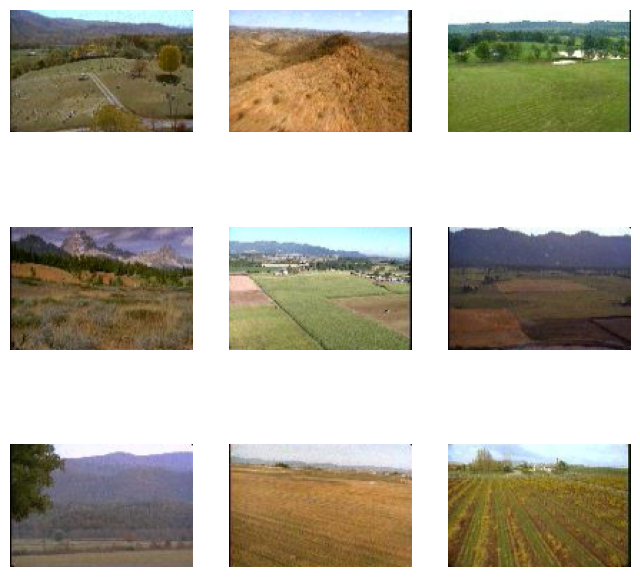

In [15]:
import torch
from torch.nn.functional import cosine_similarity

# Calculate cosine similarity
sims = cosine_similarity( query_tensor_flat , data_tensors_flat )

# Sort the similarities and get indices
sorted_indices = torch.argsort( sims , descending = True )

# Print top 8 values and their indices
for i in range (8) :
  index = sorted_indices[ i ].item()
  similarity = sims[ index ].item ()
  print( f'Index : { index } , Similarity : { similarity }')

# Display top 8 similar images
fig = plt.figure( figsize =(8 , 8) )
columns = 3
rows = 3
for i in range( columns * rows ) :
  index = sorted_indices[ i ].item()
  img = data_tensors[ index ]

  ax = fig.add_subplot( rows , columns , i + 1)
  ax.axis('off')
  ax.imshow( ToPILImage()( img ) )

plt.show ()

#USING PRETRAINED MODEL TO EXTRACT FEATURE

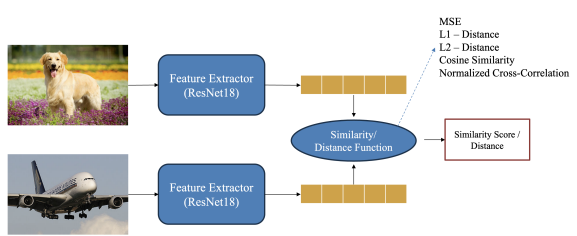

In [17]:
#USING PRETRAINED MODEL TO EXTRACT FEATURE
# Load the pretrained ResNet18 model
resnet18 = models.resnet18( pretrained = True )
# Remove the last layer to use as a feature extractor
modules = list( resnet18.children() )[: -1]
resnet18 = torch.nn.Sequential(*modules )

resnet18.eval() # Set the model to evaluation mode

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [20]:
# Function to preprocess and extract features
def extract_features( tensor , model ):
  with torch.no_grad():
    # Add batch dimension and get features
    features = model( tensor.unsqueeze(0) )
    # Flatten the features
    features = features.view( features.size(0) , -1)
    return features

# Extract features for each image and store them
feature_list = []
for tensor in data_tensors:
  #print( tensor.unsqueeze(0).shape )
  features = extract_features( tensor , resnet18 )
  feature_list.append( features )

# Stack all features into a single tensor
feature_tensor = torch.stack( feature_list ).squeeze()
print( feature_tensor.shape )
torch.save( feature_tensor , '/content/images_mr_features.pt')

torch.Size([9908, 512])


Index : 9755 , Similarity : 0.7820837497711182
Index : 6769 , Similarity : 0.7719835042953491
Index : 121 , Similarity : 0.7607699632644653
Index : 547 , Similarity : 0.7497034072875977
Index : 7512 , Similarity : 0.7469829320907593
Index : 471 , Similarity : 0.7464970350265503
Index : 8193 , Similarity : 0.7432762980461121
Index : 4482 , Similarity : 0.7350116968154907


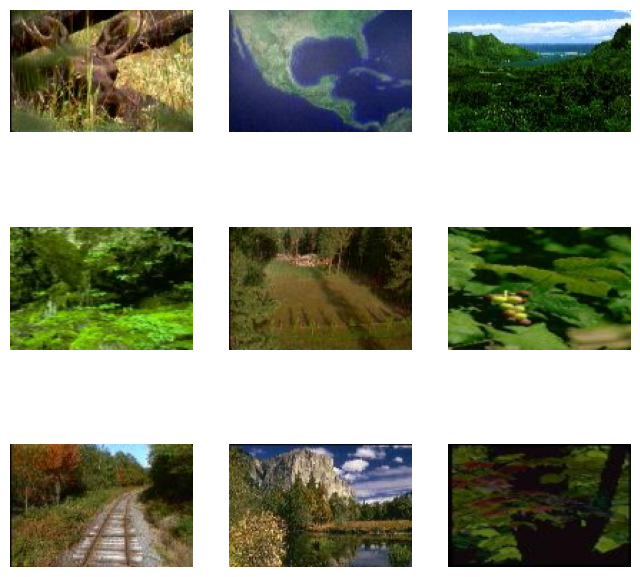

In [21]:
 # Function to preprocess and extract features
# Load the query image and extract features
query_tensor = load_image( query_img_path , transform )
query_features = extract_features( query_tensor , resnet18 )

# Load the feature tensor
feature_tensor = torch.load('/content/images_mr_features.pt')

# Calculate cosine similarity
sims = cosine_similarity( query_features , feature_tensor )

# Sort the similarities and get indices
sorted_indices = torch.argsort( sims , descending = True )

# Print top 8 values and their indices
for i in range (8) :
  index = sorted_indices[ i ].item()
  similarity = sims[ index ].item()
  print( f'Index : { index } , Similarity : { similarity }')

# Display top 8 similar images
fig = plt.figure( figsize =(8 , 8) )
columns = 3
rows = 3
for i in range( columns * rows ) :
  index = sorted_indices[ i ].item()
  img = data_tensors[ index ]

  ax = fig.add_subplot( rows , columns , i + 1)
  ax.axis('off')
  ax.imshow( ToPILImage()(img) )

plt.show()


#VECTOR DATABASE

In [27]:
# install libs
!pip install grpcio
!pip install pymilvus
# connect database
#from pymilvus import MilvusClient , connections